In [1]:
!mkdir data
!cp -r '/content/drive/MyDrive/Colab/PC_detection/train.zip' 'data/'

In [ ]:
!unzip data/train.zip -d data/train

In [3]:
!cp -r '/content/drive/MyDrive/Colab/PC_detection/test.zip' 'data/'

In [ ]:
!unzip data/test.zip -d data/test

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

# data.py

In [85]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.draw  import polygon2mask
from skimage import io
import skimage.transform as trans

from keras.preprocessing.image import ImageDataGenerator

In [23]:
def mask_folder_generator(imgs, structs, train_folder, mask_folder, target_size=(512, 512)):
    
    for im_path in imgs:
        
        # not very sure about the dtype here
        mask_class = np.zeros(target_size + (len(structs),), dtype=np.uint8)
        
        for i, s in enumerate(structs):
            slice_idx = re.findall(r'Slice_\d+', im_path)[0]
            match_path = [x for x in structs[s] if x.startswith(os.path.split(im_path)[0]) and slice_idx in x]

            if match_path:
                vertices = []
                with open(match_path[0]) as m:
                    for line in m:
                        vertices.append(tuple(map(int, re.findall(r'\d+', line))))
                new_mask = polygon2mask(target_size, vertices).T
                #applying the mask to the corresponding class_channe
                mask_class[:,:,i][new_mask] = 1

        # write mask class to mask folder
        save_path = im_path.replace(train_folder, mask_folder)
        if not os.path.exists(os.path.split(save_path)[0]):
            os.makedirs(os.path.split(save_path)[0])
        io.imsave(save_path, mask_class, check_contrast=False)

In [47]:
def trainGenerator(batch_size,data_path,train_folder,mask_folder,aug_dict,image_color_mode = "grayscale", mask_color_mode='rgba',
                  image_save_prefix='image',mask_save_prefix='mask', save_to_dir=None,target_size = (512,512),seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        os.path.join(data_path,train_folder),
        classes = None,
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        os.path.join(data_path,mask_folder),
        classes = None,
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        # img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [111]:
def testGenerator(test_imgs,target_size = (512,512),as_gray = True):
    for img_path in test_imgs:
        img = io.imread(img_path,as_gray = as_gray)
        # img = img / 255
        img = trans.resize(img,target_size)
        # img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [97]:
t1 = io.imread(test_imgs[129], as_gray=True)

In [100]:
t1.shape

(512, 512)

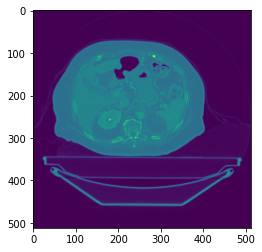

In [99]:
plt.imshow(t1)#.shape

In [101]:
t1.max()

0.6288400000000001

# model.py

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras import backend as keras

In [190]:
def dice_coef(y_true, y_pred, smooth = 1e-3):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def hard_dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = keras.flatten(keras.round(y_true[..., 0]))
    y_pred_f = keras.flatten(keras.round(y_pred[..., 0]))
    intersection = keras.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)


def hard_dice_coef_ch1(y_true, y_pred, smooth=1e-3):
    y_true_f = keras.flatten(keras.round(y_true[..., 1]))
    y_pred_f = keras.flatten(keras.round(y_pred[..., 1]))
    intersection = keras.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def hard_dice_coef_ch2(y_true, y_pred, smooth=1e-3):
    y_true_f = keras.flatten(keras.round(y_true[..., 2]))
    y_pred_f = keras.flatten(keras.round(y_pred[..., 2]))
    intersection = keras.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def hard_dice_coef_ch3(y_true, y_pred, smooth=1e-3):
    y_true_f = keras.flatten(keras.round(y_true[..., 3]))
    y_pred_f = keras.flatten(keras.round(y_pred[..., 3]))
    intersection = keras.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)


def softmax_dice_loss(y_true, y_pred):
  return categorical_crossentropy(y_true, y_pred) * 0.6 + dice_coef_loss(y_true[..., 0], y_pred[..., 0]) * 0.2 + dice_coef_loss(y_true[..., 1], y_pred[..., 1]) * 0.2 + dice_coef_loss(y_true[..., 2], y_pred[..., 2]) * 0.2 + dice_coef_loss(y_true[..., 3], y_pred[..., 3]) * 0.2



In [194]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(4, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Activation(activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    # softmax_dice_loss
    model.compile(optimizer = Adam(lr = 1e-4), loss = categorical_crossentropy, metrics = [binary_crossentropy, hard_dice_coef_ch1, hard_dice_coef])#[hard_dice_coef, hard_dice_coef_ch2, hard_dice_coef_ch3])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [125]:
model = unet()

In [126]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_390 (Conv2D)             (None, 512, 512, 64) 640         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_391 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_390[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_64 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_391[0][0]                 
___________________________________________________________________________________________

# main.py

In [ ]:
data_path = 'data/'
imgs = glob.glob(data_path + '/**/*.png', recursive =True)
test_data_path = 'data/test/'
test_imgs = glob.glob(test_data_path + '/**/*.png', recursive =True)

structs = {}
structs['tumor'] = glob.glob(data_path + '/**/*Tumor.txt', recursive =True)
structs['cc'] = glob.glob(data_path + '/**/*CA_CHA.txt', recursive =True)
structs['ps'] = glob.glob(data_path + '/**/*PV_SMV.txt', recursive =True)
structs['sma'] = glob.glob(data_path + '/**/*SMA.txt', recursive =True)

In [ ]:
mask_folder_generator(imgs, structs, 'train', 'mask', (512, 512))

In [192]:
# data augmentation arguments
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(16,data_path,'train','mask',data_gen_args,save_to_dir = None)

In [195]:
model = unet()
model_checkpoint = ModelCheckpoint('PC_unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=5,callbacks=[model_checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5


ResourceExhaustedError: ignored

In [163]:
testGene = testGenerator(test_imgs[:100])
results = model.predict_generator(testGene,10,verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


10/10 [==============================] - 1s 43ms/step


In [164]:
results.shape

(10, 512, 512, 4)

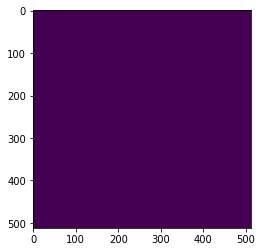

In [165]:
plt.imshow(results[5][:,:,0])

In [168]:
results[0][:,:,2].sum()

65536.0

In [169]:
512*512/4

65536.0

In [ ]:
for i in range(100):
  print(f'min: {results[5].min()}')
  print(f'max: {results[5].max()}')
  print('='*10)